In [1]:
#Date: 05/05/2021
#Location: Imaging Mind Architecture Lab, Trinity College Dublin

# Loading all the libraries

import os
from pathlib import Path

import glob
import numpy as np
import pandas as pd
from nilearn import signal
import seaborn as sns

from sklearn.manifold import TSNE

from scipy import stats
from scipy.stats import rankdata, ttest_rel, ttest_1samp

from matplotlib import pyplot as plt
import matplotlib.patheffects as PathEffects
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms

import nibabel as nib
from nilearn.input_data import NiftiLabelsMasker
from nilearn.plotting import plot_glass_brain, plot_stat_map, view_img, view_img_on_surf

from nltools.data import Brain_Data, Adjacency
from nltools.mask import roi_to_brain, expand_mask
from nltools.stats import fdr, threshold, isc

from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from sklearn import preprocessing, decomposition, manifold

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

import copy
from matplotlib.markers import TICKDOWN

%matplotlib inline


c:\Users\theab\anaconda3\envs\PRJ\lib\site-packages\nilearn\datasets\__init__.py:96: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


In [2]:
# Data directory

# Path to data in my PC
path_ASD = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group_1_ASD\\*.txt'
path_Non_ASD = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Data\\Group_2_Non_ASD\\*.txt'

# List of all the text files
sub_list_1 = [x for x in glob.iglob(path_ASD, recursive=True)]
print('Number of ASD participants:', len(sub_list_1))
sub_list_2 = [x for x in glob.iglob(path_Non_ASD, recursive=True)]
print('Number of Non-ASD participants:', len(sub_list_2))

# Initiating empty list for all time points
time_p_1 = []
time_p_2 = []

########################################################################################################################################

# Iterating over ROIs of each subject
for sub in sub_list_1:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Capturing the time points in a list
    (a, b) = activation_values.shape
    time_p_1.append(a)

# Selecting the lowest value
time_dim_1 = min(time_p_1)

# Iterating over ROIs of each subject
for sub in sub_list_2:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Capturing the time points in a list
    (a, b) = activation_values.shape
    time_p_2.append(a)

# Selecting the lowest value
time_dim_2 = min(time_p_2)

print('The minimum number of time points in ASD Cohort =', time_dim_1)
print('The minimum number of time points in Non-ASD Cohort =', time_dim_2)


Number of ASD participants: 29
Number of Non-ASD participants: 22
The minimum number of time points in ASD Cohort = 206
The minimum number of time points in Non-ASD Cohort = 206


In [3]:
# Processing data to remove all ROIs having zero value for BOLD activation (ASD)

# Initiating timeseries data as list
timeseries_3D_ASD = []

# All indices having zero value
zeroes_ASD = []

# Iterating over ROIs of each subject
for sub in sub_list_1:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Finding if there are any zeroes in the activation_values
    zero_values = np.any(activation_values == 0, axis=0)

    # Indices of zeroes in activation_values
    zero_values_ind = np.where(zero_values)

    zeroes_ASD.append(zero_values_ind)

    # Concatenating time series data for all participants (for first 'time_dim' timepoints)
    timeseries_3D_ASD.append(activation_values[0:time_dim_1, :])

# Converting timeseries data in numpy array
timeseries_3D_ASD = np.asarray(timeseries_3D_ASD)

# Unique zero values for all ROIs
zeroes_ASD = np.unique(zeroes_ASD).astype(int)

# Removing ROIs having zeroes
timeseries_3D_ASD = np.delete(timeseries_3D_ASD, zeroes_ASD, axis=2)

# Dimension check for the output
print('Dimensions of ASD dataset (Subjects, Timepoints, ROIs) =',
      timeseries_3D_ASD.shape)


Dimensions of ASD dataset (Subjects, Timepoints, ROIs) = (29, 206, 268)


In [4]:
# Processing data to remove all ROIs having zero value for BOLD activation (Non-ASD)

# Initiating timeseries data as list
timeseries_3D_Non_ASD = []

# All indices having zero value
zeroes_Non_ASD = []

# Iterating over ROIs of each subject
for sub in sub_list_2:

    # Loading BOLD signal values as an array using numpy
    activation_values = np.asarray(np.loadtxt(sub))

    # Finding if there are any zeroes in the activation_values
    zero_values = np.any(activation_values == 0, axis=0)

    # Indices of zeroes in activation_values
    zero_values_ind = np.where(zero_values)

    zeroes_Non_ASD.append(zero_values_ind)

    # Concatenating time series data for all participants (for first 'time_dim' timepoints)
    timeseries_3D_Non_ASD.append(activation_values[0:time_dim_2, :])

# Converting timeseries data in numpy array
timeseries_3D_Non_ASD = np.asarray(timeseries_3D_Non_ASD)

# Unique zero values for all ROIs
zeroes_Non_ASD = np.unique(zeroes_Non_ASD).astype(int)

# Removing ROIs having zeroes
timeseries_3D_Non_ASD = np.delete(
    timeseries_3D_Non_ASD, zeroes_Non_ASD, axis=2)

# Dimension check for the output
print('Dimensions of Non-ASD dataset (Subjects, Timepoints, ROIs) =',
      timeseries_3D_Non_ASD.shape)


Dimensions of Non-ASD dataset (Subjects, Timepoints, ROIs) = (22, 206, 268)


In [5]:
# Standardising the timeseries by z-transforming

# Initialising standard timeseries dictionary
z_timeseries_ASD = {}
z_timeseries_Non_ASD = {}

# Using z-score to standardise each value
for sub in range(timeseries_3D_ASD.shape[0]):
    z_timeseries_ASD[sub] = signal.clean(
        timeseries_3D_ASD[sub, :, :], detrend=False, standardize='zscore', standardize_confounds=False, t_r=None)
    z_timeseries_ASD[sub] = pd.DataFrame(z_timeseries_ASD[sub])

for sub in range(timeseries_3D_Non_ASD.shape[0]):
    z_timeseries_Non_ASD[sub] = signal.clean(
        timeseries_3D_Non_ASD[sub, :, :], detrend=False, standardize='zscore', standardize_confounds=False, t_r=None)
    z_timeseries_Non_ASD[sub] = pd.DataFrame(z_timeseries_Non_ASD[sub])

print('Dimensions of each subject in ASD Cohort =',
      z_timeseries_ASD[sub].shape)
print('No. of subjects in ASD Cohort =', len(z_timeseries_ASD))

print('Dimensions of each subject in Non-ASD Cohort =',
      z_timeseries_Non_ASD[sub].shape)
print('No. of subjects in Non-ASD Cohort =', len(z_timeseries_Non_ASD))


Dimensions of each subject in ASD Cohort = (206, 268)
No. of subjects in ASD Cohort = 29
Dimensions of each subject in Non-ASD Cohort = (206, 268)
No. of subjects in Non-ASD Cohort = 22


In [6]:
# Converting standardised timeseries to 3D matrix

# Initiating empty list
std_3D_ASD = []
std_3D_Non_ASD = []

for sub in z_timeseries_ASD:
    std_3D_ASD.append(z_timeseries_ASD[sub])

for sub in z_timeseries_Non_ASD:
    std_3D_Non_ASD.append(z_timeseries_Non_ASD[sub])

std_3D_ASD = np.array(std_3D_ASD)
std_3D_Non_ASD = np.array(std_3D_Non_ASD)


In [7]:
# Defining parameters

ASD_n_subs, ASD_n_ts, ASD_n_nodes = std_3D_ASD.shape
Non_ASD_n_subs, Non_ASD_n_ts, Non_ASD_n_nodes = std_3D_Non_ASD.shape


In [8]:
# Similarity Matrices for ASD using adjacency

ASD_similarity_matrices = []

for node in range(ASD_n_nodes):
    ASD_similarity_matrices.append(Adjacency(
        1 - pairwise_distances(std_3D_ASD[:, :, node], metric='correlation'), matrix_type='similarity'))

ASD_similarity_matrices = Adjacency(ASD_similarity_matrices)

# # Plot to check
# ASD_similarity_matrices[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')


In [9]:
# Similarity Matrices for Non-ASD using adjacency

Non_ASD_similarity_matrices = []

for node in range(Non_ASD_n_nodes):
    Non_ASD_similarity_matrices.append(Adjacency(1 - pairwise_distances(
        std_3D_Non_ASD[:, :, node], metric='correlation'), matrix_type='similarity'))

Non_ASD_similarity_matrices = Adjacency(Non_ASD_similarity_matrices)
# # Plotting to check
# Non_ASD_similarity_matrices[0].plot(vmin=-.25, vmax=.25, cmap='RdBu_r')


In [10]:
# Calculating per participant ISC

# For ASD Cohort
ASD_corr_mat = np.array(ASD_similarity_matrices.squareform())
ASD_mod_corr = np.where(ASD_corr_mat == 0, np.nan, ASD_corr_mat)
ASD_avg_corr = np.nanmean(ASD_mod_corr, axis=2)
# To plot per participant Mean ISC
ASD_part_ISC = np.mean(ASD_avg_corr, axis=0)

# For Non-ASD Cohort
Non_ASD_corr_mat = np.array(Non_ASD_similarity_matrices.squareform())
Non_ASD_mod_corr = np.where(Non_ASD_corr_mat == 0, np.nan, Non_ASD_corr_mat)
Non_ASD_avg_corr = np.nanmean(Non_ASD_mod_corr, axis=2)
# To plot per participant Mean ISC
Non_ASD_part_ISC = np.mean(Non_ASD_avg_corr, axis=0)


In [11]:
# Function to generate swarm plot

def swarm(array1, array2, label):
    dataf = pd.DataFrame()
    dataf['ASD'] = pd.Series(array1)
    dataf['Non-ASD'] = pd.Series(array2)
    
    # Plotting array values
    plot1 = sns.barplot(data=dataf, dodge=True, capsize=.05, errcolor='.25', errwidth=2, palette='Set2')
    plot1 = sns.swarmplot(data=dataf, palette='Set1', size=3)
    plot1.set_ylabel(f'{label}')
    plot1 = plt.show()


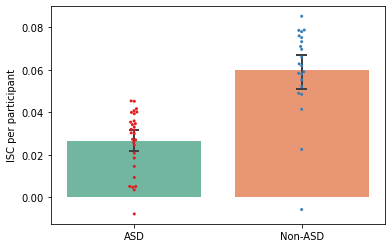

In [12]:
# Swarm plot for ISC values per participant

swarm(ASD_part_ISC, Non_ASD_part_ISC, 'ISC per participant')


In [13]:
# Yeo 7 Network

# Reading Yeo 7 csv file
yeo7 = pd.read_csv(
    'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\Templates and Inputs\\shen_268_parcellation_networklabels[84497].csv')

# Initiating the empty dictionary
network = {}

# Zipping 2 columns in the file
z_list = list(zip(yeo7['Network'], yeo7['Node']))

for a, b in z_list:
    if a not in network:
        network[a] = []
    if a in network:
        network[a].append(b)

# Sanity check for all the assignment of all values
sum = 0

for i in network:
    count = len(network[i])
    print('Network', i, ', No. of regions =', count)
    sum = sum+count

print('Number of items sorted in keys =', sum)


Network 2 , No. of regions = 34
Network 4 , No. of regions = 90
Network 3 , No. of regions = 20
Network 1 , No. of regions = 29
Network 5 , No. of regions = 50
Network 8 , No. of regions = 18
Network 6 , No. of regions = 18
Network 7 , No. of regions = 9
Number of items sorted in keys = 268


In [14]:
# Dictionary of ROI correlations for each participant

ASD_roi_isc_pp = {}
Non_ASD_roi_isc_pp = {}

for i in range(len(ASD_avg_corr)):
    ASD_roi_isc_pp[i] = ASD_avg_corr[i]
    Non_ASD_roi_isc_pp[i] = Non_ASD_avg_corr[i]


In [15]:
# Dictionary of Networkwise Mean ISC values

ASD_network_isc = {}
Non_ASD_network_isc = {}

sanity_count = 0

for j in network:
    # print (f'Number of entries in key {j}: {len(network[j])}')
    ASD_temp = []
    Non_ASD_temp = []
    for keys in network[j]:
        ASD_temp.append(ASD_roi_isc_pp[keys-1])
        Non_ASD_temp.append(Non_ASD_roi_isc_pp[keys-1])
    ASD_network_isc[j] = ASD_temp
    Non_ASD_network_isc[j] = Non_ASD_temp

    if len(network[j]) == len(ASD_network_isc[j]) & len(network[j]) == len(Non_ASD_network_isc[j]):
        sanity_count = sanity_count+1

    # Converting key type from list to numpy array
    ASD_network_isc[j] = np.array(ASD_network_isc[j])
    ASD_network_isc[j] = np.mean(ASD_network_isc[j], axis=0)
    Non_ASD_network_isc[j] = np.array(Non_ASD_network_isc[j])
    Non_ASD_network_isc[j] = np.mean(Non_ASD_network_isc[j], axis=0)

print(f'Number of sorted networks: {sanity_count}')


Number of sorted networks: 8


SW test statistic for ASD Cohort is 0.9176684021949768
p-value for SW test for ASD Cohort is 0.02662481926381588
Mean ISC values for ASD cohort do not follow Gaussian distribution


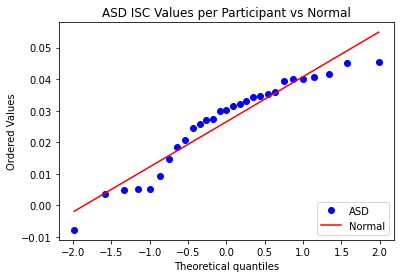

SW test statistic for ASD Cohort is 0.8537441492080688
p-value for SW test for ASD Cohort is 0.003956637345254421
Mean ISC values for Non-ASD cohort do not follow Gaussian distribution


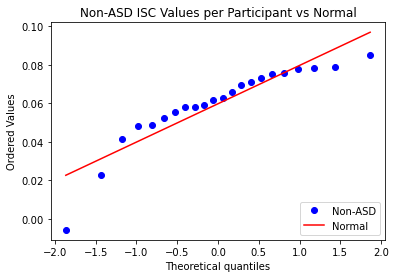

In [16]:
# Shapiro-Wilk Test for Normality

# ASD Cohort
sw_test_ind_ASD, sw_p_ind_ASD = stats.shapiro(ASD_part_ISC)
print('SW test statistic for ASD Cohort is', sw_test_ind_ASD)
print('p-value for SW test for ASD Cohort is', sw_p_ind_ASD)

if sw_p_ind_ASD > 0.05:
    print('Mean ISC values for ASD cohort follow Gaussian distribution')
else:
    print('Mean ISC values for ASD cohort do not follow Gaussian distribution')

# Q-Q plot
stats.probplot(ASD_part_ISC, dist='norm', plot=plt)
plt.title('ASD ISC Values per Participant vs Normal')
plt.legend(["ASD", "Normal"], loc="lower right")
plt.show()

# Non-ASD Cohort
sw_test_ind_non_ASD, sw_p_ind_non_ASD = stats.shapiro(Non_ASD_part_ISC)
print('SW test statistic for ASD Cohort is', sw_test_ind_non_ASD)
print('p-value for SW test for ASD Cohort is', sw_p_ind_non_ASD)

if sw_p_ind_non_ASD > 0.05:
    print('Mean ISC values for Non-ASD cohort follow Gaussian distribution')
else:
    print('Mean ISC values for Non-ASD cohort do not follow Gaussian distribution')

# Q-Q plot
stats.probplot(Non_ASD_part_ISC, dist='norm', plot=plt)
plt.title('Non-ASD ISC Values per Participant vs Normal')
plt.legend(["Non-ASD", "Normal"], loc="lower right")
plt.show()


In [17]:
# Mann-Whitney U test

print('Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation')

mn_stats_pp, p_value_pp = stats.mannwhitneyu(
    ASD_part_ISC, Non_ASD_part_ISC, alternative='two-sided')
print('MN test statistic is', mn_stats_pp)
print('p-value for MN test is', p_value_pp)

if p_value_pp <= 0.05:
    print('Null hypothesis is rejected, hence ASD group != Non-ASD group')
else:
    print('Null hypothesis is retained, hence ASD group = Non-ASD group')


Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation
MN test statistic is 51.0
p-value for MN test is 3.628597339716713e-07
Null hypothesis is rejected, hence ASD group != Non-ASD group


In [18]:
# Function for test of normality and comparison

# Helper Function

# Shapiro Test
def shapiro(arr, label):
    sw_test, sw_p = stats.shapiro(arr)
    print(f'SW test statistic for {label} is {sw_test}')
    print(f'p-value for {label} is {sw_p}')
    return sw_test, sw_p

# Q-Q plot
def qqplot(arr, label):
    stats.probplot(arr, dist='norm', plot=plt)
    plt.title(f'{label} vs Normal')
    plt.legend([f'{label}', "Normal"], loc="lower right")
    plt.show()

# Major Function (Array1 = ASD Data, Array2 = Non-ASD Data, Label = 'Network')
network_ps = []

def compare(array1, array2, label):

    # swarm1(array1, array2, 'Comparison of '+label+' Network', start, end, height, displaystring, linewidth=1.2, markersize=8, boxpad=0.3, fontsize=15, color='k')

    # ASD Cohort (array1)
    _, sw_p_ASD = shapiro(array1, label)
    # if sw_p_ASD > 0.05:
        # print('Values for ASD cohort follow Gaussian distribution')
    # else:
        # print('Values for ASD cohort do not follow Gaussian distribution')
    # qqplot(array1, label+' (ASD)')

    # Non-ASD Cohort (array2)
    _, sw_p_nASD = shapiro(array2, label)
    # if sw_p_nASD > 0.05:
        # print('Values for Non-ASD cohort follow Gaussian distribution')
    # else:
        # print('Values for Non-ASD cohort do not follow Gaussian distribution')
    # qqplot(array2, label+' (Non-ASD)')

    if sw_p_ASD > 0.05 and sw_p_nASD > 0.05:
        print('Running t-test...')
        # t-Test
        # print('Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation')
        t_value, t_p_value = stats.ttest_ind(array2, array1)
        network_ps.append(t_p_value)
        print('Test statistic is', t_value)
        print('p-value for two tailed test is', t_p_value)

        # if t_p_value <= 0.05:
        #     print('Null hypothesis is rejected, hence ASD group != Non-ASD group')
        # else:
        #     print('Null hypothesis is retained, hence ASD group = Non-ASD group')
    else:
        print('Running Mann-Whitney U test...')
        # Mann-Whitney U test
        # print('Null Hypothesis: ASD and non-ASD cohorts have similar brain synchronisation')
        mn_stats, mn_p_value = stats.mannwhitneyu(array1, array2, alternative='two-sided')
        network_ps.append(mn_p_value)
        print('MN test statistic is', mn_stats)
        print('p-value for MN test is', mn_p_value)
        # if mn_p_value <= 0.05:
        #     print('Null hypothesis is rejected, hence ASD group != Non-ASD group')
        # else:
        #     print('Null hypothesis is retained, hence ASD group = Non-ASD group')


In [19]:
def swarm1(array1, array2, label, start, end, height, displaystring, linewidth=1.2, markersize=8, boxpad=0.3, fontsize=15, color='k', c_graph='black', y_axis='Mean ISC per participant'):
    dataf = pd.DataFrame()
    dataf['ASD'] = pd.Series(array1)
    dataf['Non-ASD'] = pd.Series(array2)

    # Plotting array values
    plot1 = sns.barplot(data=dataf, dodge=True, capsize=.05, errcolor='.25', errwidth=2, palette='Set2')
    plot1 = sns.swarmplot(data=dataf, palette='Set1', size=3)
    plot1.set_title(f'{label}', color=c_graph)
    plot1.set_ylabel(f'{y_axis}')

    def significance_bar(start, end, height, displaystring, linewidth=1.2, markersize=8, boxpad=0.3, fontsize=15, color='k'):
        # draw a line with downticks at the ends
        plt.plot([start, end], [height]*2, '-', color=color, lw=linewidth, marker=TICKDOWN, markeredgewidth=linewidth, markersize=markersize)
        # draw the text with a bounding box covering up the line
        plt.text(0.5*(start+end), height, displaystring, ha='center', va='center', bbox=dict(
            facecolor='1.', edgecolor='none', boxstyle='Square,pad='+str(boxpad)), size=fontsize)

    plot1 = significance_bar(start, end, height, displaystring, linewidth=1.2, markersize=8, boxpad=0.3, fontsize=15, color='k')
    plot1 = plt.show()


In [20]:
# Running analysis

Net_list = ['VIS', 'SMN', 'DAN', 'VAN', 'LIM', 'FPN', 'DMN', 'SUB']
colours = ['#a34dae', '#7699c2', '#3c992a', '#e25eff', '#d2e1ae', '#f1ba33', '#db707c', '#373434']

for net, name in enumerate(Net_list):
    compare(ASD_network_isc[net+1], Non_ASD_network_isc[net+1], name)


SW test statistic for VIS is 0.9633002281188965
p-value for VIS is 0.3952246606349945
SW test statistic for VIS is 0.9321392178535461
p-value for VIS is 0.13595430552959442
Running t-test...
Test statistic is 4.874928656141735
p-value for two tailed test is 1.1863640661906353e-05
SW test statistic for SMN is 0.9280654191970825
p-value for SMN is 0.04902910068631172
SW test statistic for SMN is 0.8858669996261597
p-value for SMN is 0.01566356047987938
Running Mann-Whitney U test...
MN test statistic is 80.0
p-value for MN test is 5.734835187141054e-06
SW test statistic for DAN is 0.968364953994751
p-value for DAN is 0.5162285566329956
SW test statistic for DAN is 0.9816678762435913
p-value for DAN is 0.9400486350059509
Running t-test...
Test statistic is 4.8291336919879555
p-value for two tailed test is 1.3863918315827424e-05
SW test statistic for VAN is 0.9586067199707031
p-value for VAN is 0.30360835790634155
SW test statistic for VAN is 0.8154639005661011
p-value for VAN is 0.0008825

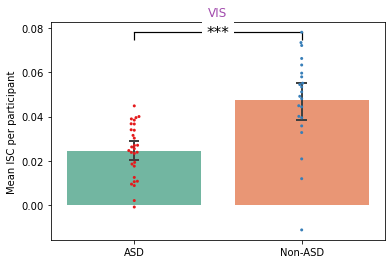

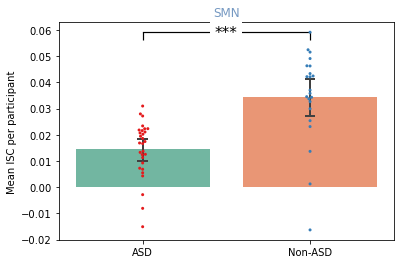

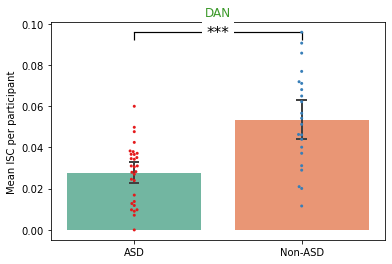

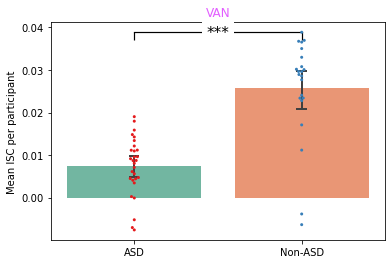

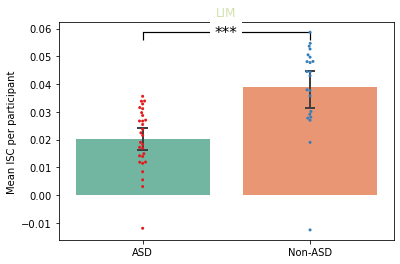

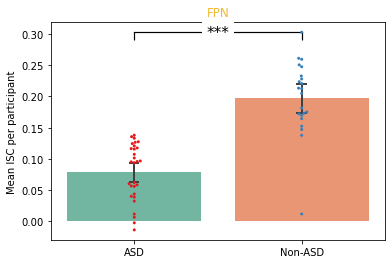

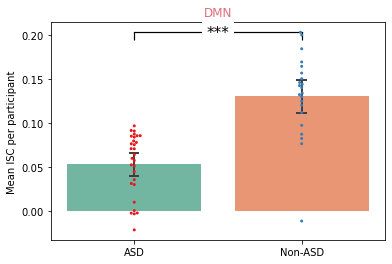

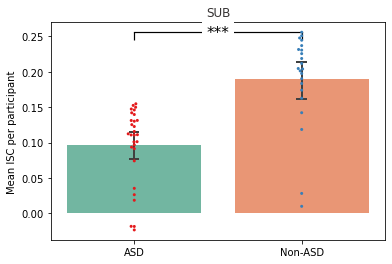

In [21]:
from statsmodels.sandbox.stats.multicomp import multipletests

p_adjusted = multipletests(network_ps, alpha=0.05, method='bonferroni')

bar_width = 0.5

for net, p in enumerate(p_adjusted[1]):
    if p >= 0.05:
        displaystring = r'n.s.'
    elif p < 0.001:
        displaystring = r'***'
    elif p < 0.01:
        displaystring = r'**'
    else:
        displaystring = r'*'

    offset = 0.02
    height =  max(max(pd.Series(ASD_network_isc[net+1])), max(pd.Series(Non_ASD_network_isc[net+1])))
    bar_centers = np.array([0, 2])*bar_width
    swarm1(ASD_network_isc[net+1], Non_ASD_network_isc[net+1], Net_list[net], bar_centers[0], bar_centers[1], height, displaystring, linewidth=1.2, markersize=8, boxpad=0.3, fontsize=15, color='k', c_graph=colours[net], y_axis='Mean ISC per participant')


SW test statistic for ISC per participant is 0.9176684021949768
p-value for ISC per participant is 0.02662481926381588
SW test statistic for ISC per participant is 0.8537441492080688
p-value for ISC per participant is 0.003956637345254421
Running Mann-Whitney U test...
MN test statistic is 51.0
p-value for MN test is 3.628597339716713e-07


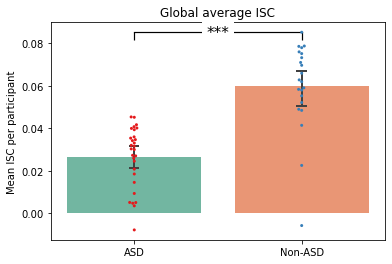

In [22]:
# Global Mean ISC comparison

network_ps = []
compare(ASD_part_ISC, Non_ASD_part_ISC, 'ISC per participant')

bar_width = 0.5

for net, p in enumerate(network_ps):
    if p >= 0.05:
        displaystring = r'n.s.'
    elif p < 0.001:
        displaystring = r'***'
    elif p < 0.01:
        displaystring = r'**'
    else:
        displaystring = r'*'

    offset = 0.02
    height = max(max(pd.Series(ASD_part_ISC)), max(pd.Series(Non_ASD_part_ISC)))
    bar_centers = np.array([0, 2])*bar_width
    swarm1(ASD_part_ISC, Non_ASD_part_ISC, 'Global average ISC', bar_centers[0], bar_centers[1], height, displaystring, linewidth=1.2, markersize=8, boxpad=0.3, fontsize=15, color='k', c_graph='black', y_axis='Mean ISC per participant')


In [23]:
# ISC (median-centric) per ROI comparison
path_ASD = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\ASD\\Run_2_ASD_ISC_per_ROI.csv'
path_nASD = 'C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Non_ASD\\Run_2_Non_ASD_ISC_per_ROI.csv'

asd = pd.read_csv(path_ASD)
nasd = pd.read_csv(path_nASD)

asd_isc = asd['ISC']
nasd_isc = nasd['ISC']

print (len(asd_isc))
print (len(nasd_isc))


58
75


SW test statistic for Mean ISC per ROI is 0.839310884475708
p-value for Mean ISC per ROI is 2.0718864561786177e-06
SW test statistic for Mean ISC per ROI is 0.8889029026031494
p-value for Mean ISC per ROI is 7.809026101313066e-06
Running Mann-Whitney U test...
MN test statistic is 839.0
p-value for MN test is 1.3653706242574983e-09


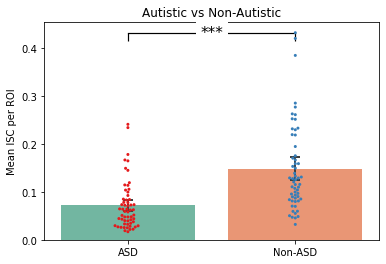

In [24]:
network_ps = []
compare(asd_isc, nasd_isc,'Mean ISC per ROI')

bar_width = 0.5

for net, p in enumerate(network_ps):
    if p >= 0.05:
        displaystring = r'n.s.'
    elif p < 0.001:
        displaystring = r'***'
    elif p < 0.01:
        displaystring = r'**'
    else:
        displaystring = r'*'

    height = max(max(pd.Series(asd_isc)), max(pd.Series(nasd_isc)))
    bar_centers = np.array([0, 2])*bar_width
    swarm1(asd_isc, nasd_isc, 'Autistic vs Non-Autistic', bar_centers[0], bar_centers[1], height, displaystring, linewidth=1.2, markersize=8, boxpad=0.3, fontsize=15, color='k', c_graph='black', y_axis='Mean ISC per ROI')


In [26]:
# Exporting Global mean ISC values

globm = pd.DataFrame()
globm['ASD'] = pd.Series(ASD_part_ISC)
globm['Non_ASD'] = pd.Series(Non_ASD_part_ISC)
globm.to_csv('C:\\Users\\theab\\Documents\\Trinity Dublin\\MSc Neuroscience\\Courses\\PRJ - final\\Project\\WHMSTS\\Code and Results\\Files\\Common\\Global_Mean_ISC.csv', index=False)
